# Import necessary libraries


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from metrics import F1Score


2023-03-22 12:19:22.171315: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Configure GPU memory growth


In [2]:
def configure_gpu_memory_growth():
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.list_physical_devices('GPU')

configure_gpu_memory_growth()

2023-03-22 12:19:25.648116: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-22 12:19:25.649218: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-22 12:19:25.683449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 12:19:25.683776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 950M computeCapability: 5.0
coreClock: 1.124GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 26.82GiB/s
2023-03-22 12:19:25.683826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-22 12:19:25.732915: I tensorflow/stream_executor/platform/defa

# Load and preprocess data


In [3]:
def load_and_preprocess_data(data_dir, image_size=(224, 224)):
    data = tf.keras.preprocessing.image_dataset_from_directory(data_dir, image_size=image_size)
    data = data.map(lambda x, y: (x / 255, y))
    
    train_size = int(len(data) * 0.8)
    val_size = int(len(data) * 0.2)
    
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    
    return train, val

data_dir = 'dataset'
train_data, val_data = load_and_preprocess_data(data_dir)

Found 153 files belonging to 2 classes.


2023-03-22 12:19:26.096749: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 12:19:26.098438: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-22 12:19:26.098704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 12:19:26.099016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 950M computeCapability: 5.0
coreClock: 1.124GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 26.82GiB

# Create model


In [4]:
def create_model(input_shape=(224, 224, 3)):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg16.layers:
        layer.trainable = False
        
    model = Sequential()
    model.add(vgg16)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', F1Score()])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,320,449
Trainable params: 1,605,761
Non-trainable params: 14,714,688
_________________________________________________________________


# Train and evaluate model


In [5]:
def train_and_evaluate_model(model, train_data, val_data, logdir='logs', epochs=15):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    hist = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[tensorboard_callback, early_stop])
    return hist

hist = train_and_evaluate_model(model, train_data, val_data)


2023-03-22 12:19:30.496871: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-22 12:19:30.496907: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-22 12:19:30.496941: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-03-22 12:19:30.502077: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-03-22 12:19:30.602478: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-03-22 12:19:30.603205: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-03-22 12:19:30.633926: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-22 12:19

Epoch 1/15


2023-03-22 12:19:31.972104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-22 12:19:33.324216: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-03-22 12:19:34.646077: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-03-22 12:19:34.675119: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-22 12:19:36.155184: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-03-22 12:1

1/4 [======>.......................] - ETA: 45s - loss: 0.7520 - accuracy: 0.3125 - f1_score: 0.4500

2023-03-22 12:19:46.013808: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-03-22 12:19:46.013872: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-03-22 12:19:46.014423: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


2/4 [==============>...............] - ETA: 1s - loss: 0.7098 - accuracy: 0.4297 - f1_score: 0.5755 

2023-03-22 12:19:46.645422: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-03-22 12:19:46.649356: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-03-22 12:19:46.650786: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-03-22 12:19:46.654725: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2023_03_22_12_19_46
2023-03-22 12:19:46.655637: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2023_03_22_12_19_46/starplatinum-X550JX.trace.json.gz
2023-03-22 12:19:46.665139: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2023_03_22_12_19_46
2023-03-22 12:19:46.666956: I tensorflow/core/profiler/rpc/client/save_profile.cc:143]

4/4 [==============================] - ETA: 0s - loss: 0.7671 - accuracy: 0.5020 - f1_score: 0.6509

2023-03-22 12:19:51.293879: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-03-22 12:19:51.293945: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-03-22 12:19:53.805661: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overh

4/4 [==============================] - 30s 5s/step - loss: 0.7780 - accuracy: 0.5188 - f1_score: 0.6680 - val_loss: 0.4937 - val_accuracy: 0.7200 - val_f1_score: 0.8372
Epoch 2/15
4/4 [==============================] - 6s 1s/step - loss: 0.4673 - accuracy: 0.8146 - f1_score: 0.8863 - val_loss: 0.4635 - val_accuracy: 0.8800 - val_f1_score: 0.9091
Epoch 3/15
4/4 [==============================] - 6s 1s/step - loss: 0.3718 - accuracy: 0.9135 - f1_score: 0.9447 - val_loss: 0.2252 - val_accuracy: 0.9200 - val_f1_score: 0.9444
Epoch 4/15
4/4 [==============================] - 6s 1s/step - loss: 0.2383 - accuracy: 0.9094 - f1_score: 0.9418 - val_loss: 0.1861 - val_accuracy: 0.9200 - val_f1_score: 0.9474
Epoch 5/15
4/4 [==============================] - 5s 1s/step - loss: 0.1631 - accuracy: 0.9354 - f1_score: 0.9560 - val_loss: 0.1205 - val_accuracy: 0.9600 - val_f1_score: 0.9778
Epoch 6/15
4/4 [==============================] - 5s 1s/step - loss: 0.1088 - accuracy: 0.9802 - f1_score: 0.9862 -

# Visualize loss


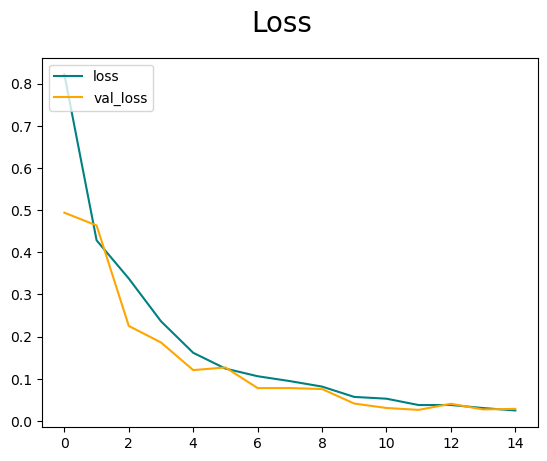

In [6]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Visualize accuracy and F1 score


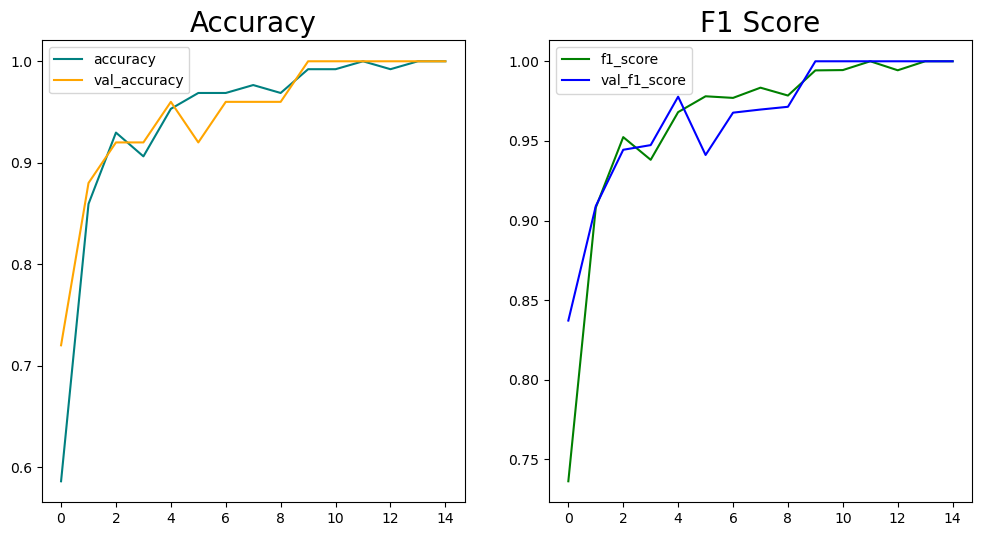

In [7]:
from metrics import *
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy and validation accuracy on the first subplot
ax1.plot(hist.history['accuracy'], color='teal', label='accuracy')
ax1.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax1.set_title('Accuracy', fontsize=20)
ax1.legend(loc="upper left")

# Plot F1 scores and validation F1 scores on the second subplot
ax2.plot(hist.history['f1_score'], color='green', label='f1_score')
ax2.plot(hist.history['val_f1_score'], color='blue', label='val_f1_score')
ax2.set_title('F1 Score', fontsize=20)
ax2.legend(loc="upper left")

plt.show()


# Load test data

In [8]:
def load_test_data(data_dir, image_size=(224, 224)):
    test_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir, image_size=image_size)
    return test_data

test_data_dir = 'test_images'
test_data = load_test_data(test_data_dir)

Found 10 files belonging to 2 classes.


# Show sample test images


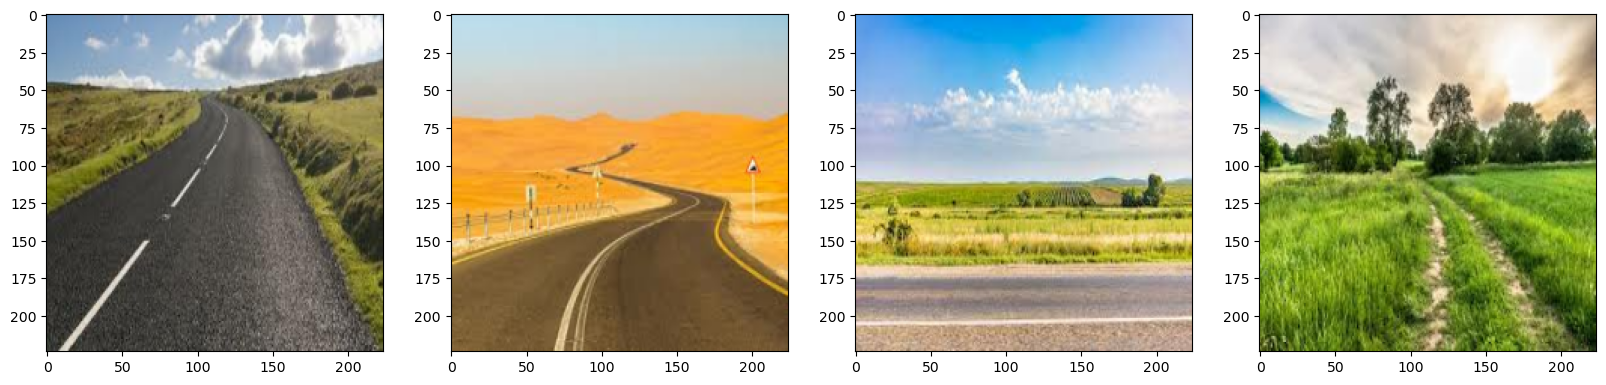

In [9]:
# pylint: disable=invalid-name
def show_sample_test_images(test_data, ncols=4, class_names=['Field', 'Road']):
    test_data_iterator = test_data.as_numpy_iterator()
    batch = test_data_iterator.next()
    fig, ax = plt.subplots(ncols=ncols, figsize=(20, 20))
    for idx, img in enumerate(batch[0][:ncols]):
        ax[idx].imshow(img.astype(int))
    plt.show()

show_sample_test_images(test_data)

# Predict and visualize results on test images

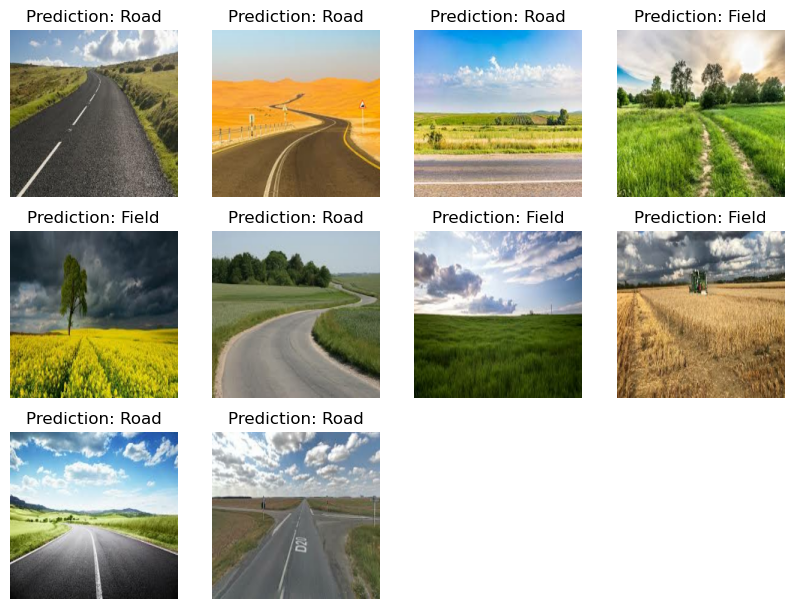

In [10]:
def visualize_predictions(model, test_data, class_names=['Field', 'Road']):
    test_data_iterator = test_data.as_numpy_iterator()
    batch = test_data_iterator.next()
    num_images = len(batch[0])
    nrows = int(np.ceil(np.sqrt(num_images)))
    ncols = int(np.ceil(num_images / nrows))+1
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    for i, axi in enumerate(ax.flat):
        if i < num_images:
            img = batch[0][i]
            axi.imshow(img.astype(int))
            pred = model.predict(np.expand_dims(img / 255, axis=0))
            pred_class = class_names[int(np.round(pred))]
            axi.title.set_text(f"Prediction: {pred_class}")
            axi.axis('off')
        else:
            axi.axis('off')
            axi.set_visible(False)
    plt.show()


visualize_predictions(model, test_data)

# Evaluate the model

In [11]:
def evaluate_model(model: tf.keras.Model, test_data: tf.data.Dataset):
    accuracy_metric = tf.keras.metrics.BinaryAccuracy()
    f1_metric = F1Score()
    
    for X, y_true in test_data.as_numpy_iterator():
        y_pred = model.predict(X/255)
        accuracy_metric.update_state(y_true, y_pred)
        f1_metric.update_state(y_true, y_pred)

    accuracy = accuracy_metric.result().numpy()
    f1_score = f1_metric.result().numpy()

    return accuracy, f1_score

accuracy, f1_score = evaluate_model(model, test_data)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 1.0000
F1 Score: 1.0000


# Save the model

In [13]:
def save_model(model, save_path='models', model_name='road_field_classifier_vgg16.h5'):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model.save(os.path.join(save_path, model_name))

save_model(model)

# Inference function 

In [ ]:
def infer_image(model_path, image_path, class_names=['Field', 'Road'], image_size=(224, 224)):
    # Load the model
    model = tf.keras.models.load_model(model_path, custom_objects={'F1Score': F1Score})

    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    pred_class = class_names[int(np.round(prediction))]
    return pred_class

model_path = 'models/road_field_classifier_vgg16.h5'
image_path = 'test_images/road/2.jpeg'
predicted_class = infer_image(model_path, image_path)
print(f"Predicted class: {predicted_class}")